In [10]:
import pandas as pd
import tp3 as lib
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
import sklearn
import scikitplot as skplt
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
lib = reload(lib)
sns.plt = plt

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Los datos fueron extraidos del tp2

In [11]:
df = pd.read_csv('datos.csv', sep=' ')

print df.head()

   sujeto         delta         theta         alpha          beta  \
0       0  4.343248e-12  8.632094e-13  6.974374e-13  3.389951e-13   
1       1  2.925933e-12  1.526239e-12  6.247791e-12  3.256419e-13   
2       2  3.137522e-12  1.066840e-12  3.155120e-12  1.804304e-13   
3       3  3.754393e-12  1.203367e-12  5.461378e-12  2.723860e-13   
4       4  2.713553e-12  2.125486e-12  2.993980e-12  2.811052e-13   

          gamma  info_intra  info_inter  delta_normalizada  theta_normalizada  \
0  1.805058e-13     92.5600  128.991522           0.676161           0.134385   
1  7.748693e-14     83.2524  128.161690           0.263524           0.137461   
2  4.018060e-14     81.9084  128.238238           0.413916           0.140742   
3  1.123612e-13     85.6552  127.468520           0.347504           0.111383   
4  4.645266e-14     83.5424  128.971964           0.332520           0.260458   

   alpha_normalizada  beta_normalizada  gamma_normalizada     delta_std  \
0           0.108578   

La función roc_and_roll es nuestra implementación de la roc, sin embargo en el resto del tp usamos la de sklearn

In [18]:
def graficar_roc(df, feature):
    roc = lib.roc_and_roll(df, feature)
    auc = metrics.auc(roc["fpr"], roc["tpr"])

    plt.figure()
    lw = 2
    plt.plot(roc['fpr'], roc['tpr'], color='darkorange',
             lw=lw )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str.capitalize(feature) + ' - AUC: ' + str(auc))
    plt.legend(loc="lower right")
    plt.show()


In [19]:
def logistic_regression_roc(feat):
    X = np.array(df[feat]).reshape(-1,1)
    y = np.array(df["tipo"])
    y = preprocessing.label_binarize(y, classes=["disminuido", "normal"])
    n_classes = y.shape[1]
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    classifier = LogisticRegression().fit(X, y)
    y_score = classifier.fit(X, y).decision_function(X)
    
    show_roc(y,y_score,n_classes)

def support_vector_machine_roc():
    df_tmp = pd.read_csv('datos.csv', sep=' ')
    tipos = df_tmp["tipo"]
    features = df_tmp
    del features["tipo"]
    X = np.array(features)
    y = np.array(tipos)
    y = preprocessing.label_binarize(y, classes=["disminuido", "normal"])
    n_classes = y.shape[1]
    classifier = SVC().fit(X, y)
    y_score = classifier.decision_function(X)
    show_roc(y,y_score,n_classes)
    
def pipeline_svm_roc(porcentaje):
    df_tmp = pd.read_csv('datos.csv', sep=' ')
    tipos = df_tmp["tipo"]
    features = df_tmp
    del features["tipo"]
    X = np.array(features)
    y = np.array(tipos)
    y = preprocessing.label_binarize(y, classes=["disminuido", "normal"])
    n_classes = y.shape[1]
    scaler = preprocessing.StandardScaler()
    selector = SelectPercentile(percentile=porcentaje)
    classifier = SVC()
    pipeline = Pipeline([('scaler', scaler), ('selector', selector), ('classifier', classifier)])
    
    df_tmp = pd.read_csv('datos.csv', sep=' ')
    tipos = df_tmp["tipo"]
    features = df_tmp
    del features["tipo"]
    X = np.array(features)
    y = np.array(tipos)
    y = preprocessing.label_binarize(y, classes=["disminuido", "normal"])
    n_classes = y.shape[1]
    
    pipeline.fit(X,y)
    y_score = pipeline.decision_function(X)
    show_roc(y,y_score,n_classes)
        
def show_roc(y,y_score,n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y, y_score)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    try:
        plt.title(str.capitalize(feat) + ' - AUC: ' + str(roc_auc[0]))
    except NameError:
        plt.title('AUC: ' + str(roc_auc[0]))
    
    
    plt.legend(loc="lower right")
    plt.show()

In [20]:
def cross_validation_score(df, feature):
    X = np.array(df[feature]).reshape(-1,1)
    y = np.array(df["tipo"])
    scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=4)
    print feature +" "+ str(scores.mean())

In [21]:
def get_scores_for_roc(feat):
    X = np.array(df[feat]).reshape(-1,1)
    y = np.array(df["tipo"])
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    model = LogisticRegression().fit(X, y)
    X = np.array(df[feat]).reshape(-1,1)
    X = scaler.transform(X)
    return map(lambda x: x[0], model.predict_proba(X))

# Ejercicio 1 a: Computamos y graficamos la curva ROC para cada feature

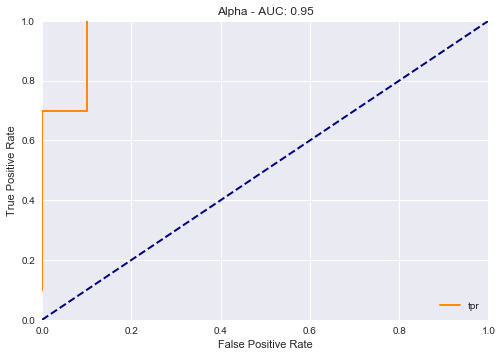

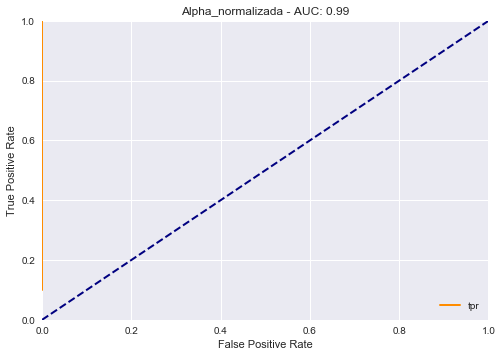

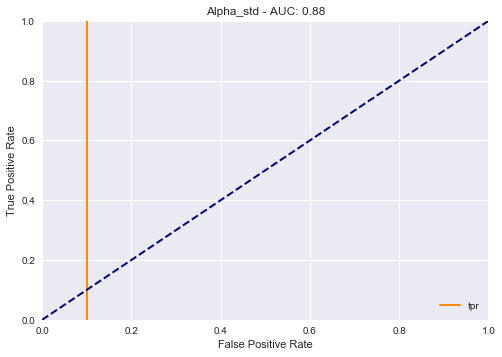

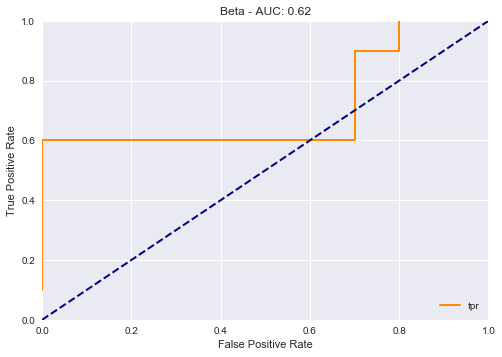

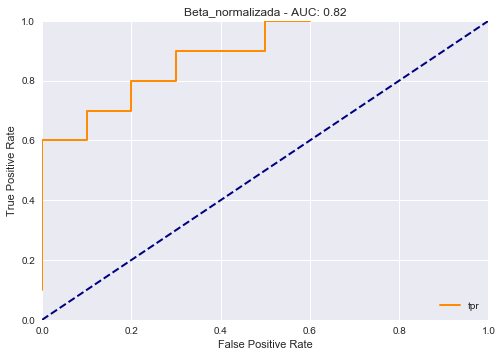

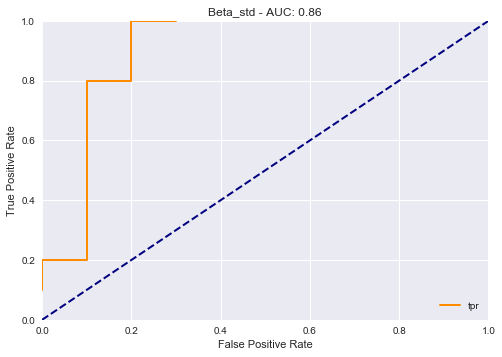

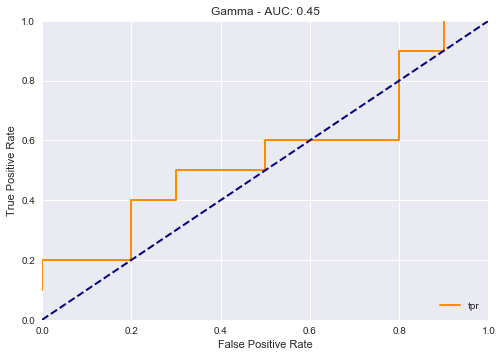

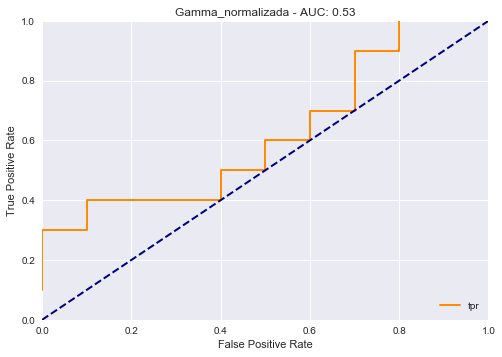

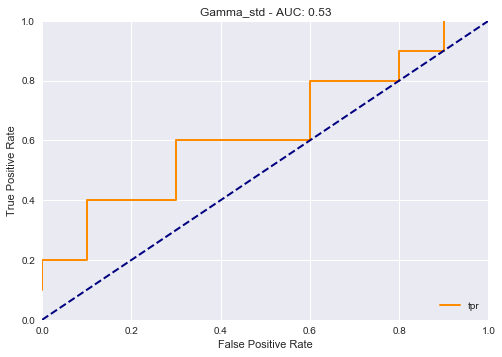

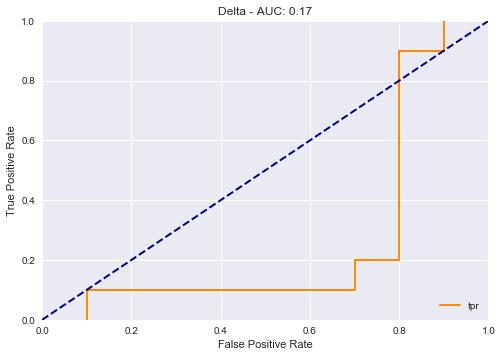

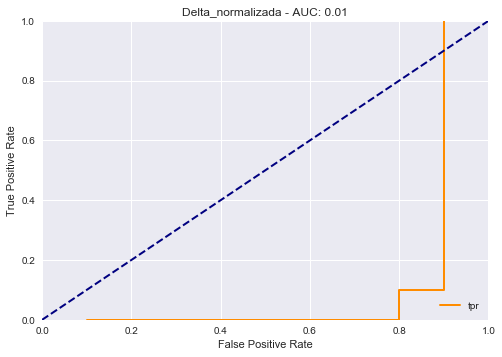

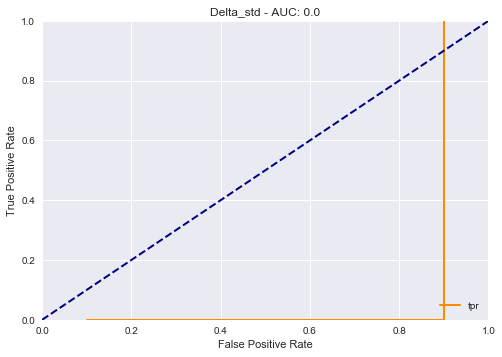

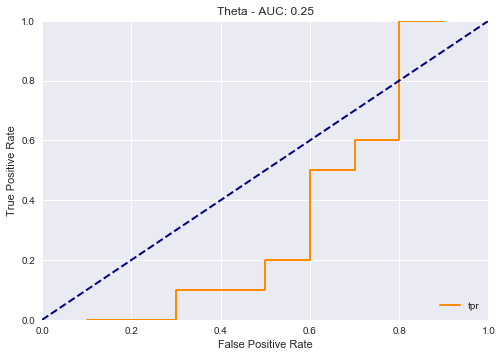

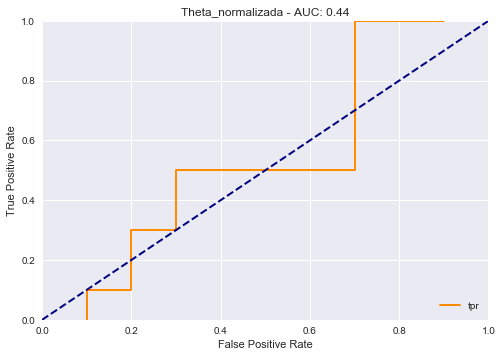

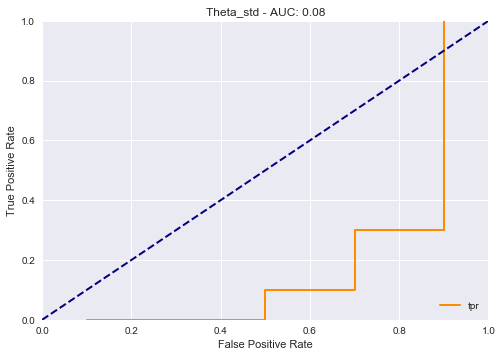

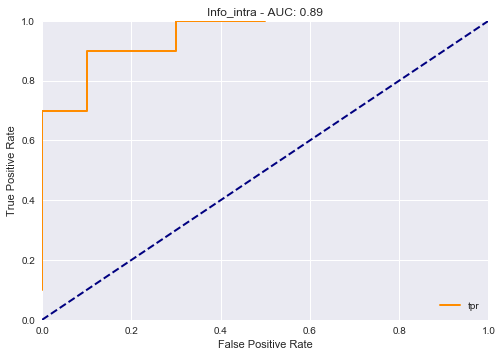

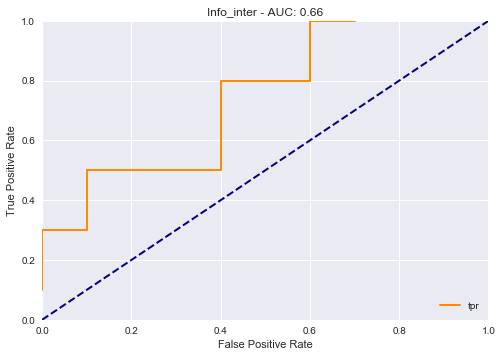

In [22]:
graficar_roc(df,"alpha")
graficar_roc(df,"alpha_normalizada")
graficar_roc(df,"alpha_std")
graficar_roc(df,"beta")
graficar_roc(df,"beta_normalizada")
graficar_roc(df,"beta_std")
graficar_roc(df,"gamma")
graficar_roc(df,"gamma_normalizada")
graficar_roc(df,"gamma_std")
graficar_roc(df,"delta")
graficar_roc(df,"delta_normalizada")
graficar_roc(df,"delta_std")
graficar_roc(df,"theta")
graficar_roc(df,"theta_normalizada")
graficar_roc(df,"theta_std")
graficar_roc(df,"info_intra")
graficar_roc(df,"info_inter")

# Ejercicio 1b: Calculamos el score de cross validation y graficamos la curva ROC usando Logistic Regression para cada feature

In [23]:
for feat in df.columns:
    if feat != "sujeto" and feat != "tipo":
        cross_validation_score(df, feat)


delta 0.55
theta 0.55
alpha 0.55
beta 0.55
gamma 0.55
info_intra 0.7
info_inter 0.55
delta_normalizada 0.6
theta_normalizada 0.55
alpha_normalizada 0.895833333333
beta_normalizada 0.55
gamma_normalizada 0.55
delta_std 0.55
theta_std 0.55
alpha_std 0.55
beta_std 0.55
gamma_std 0.55


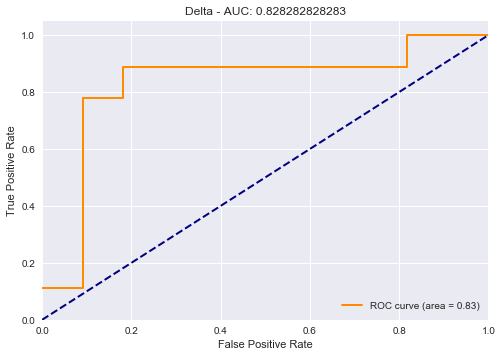

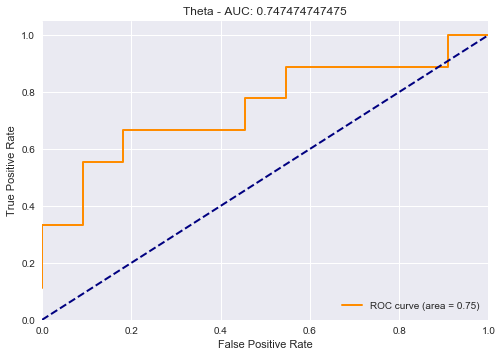

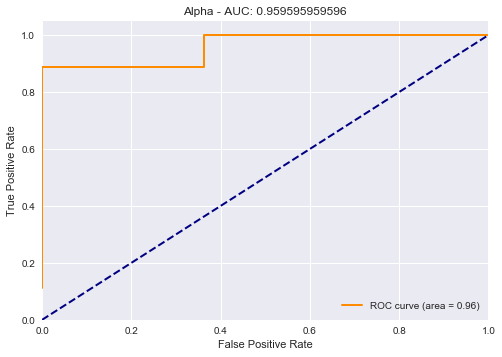

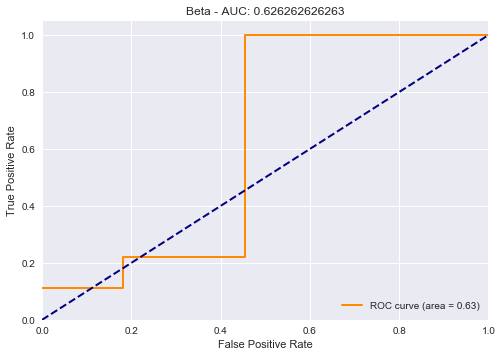

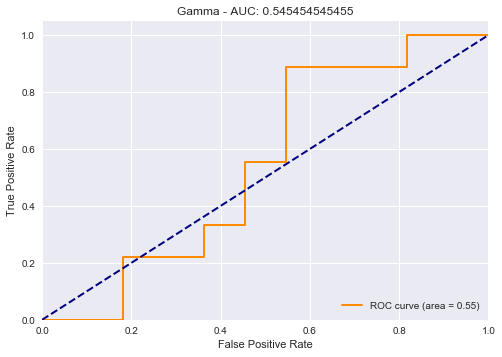

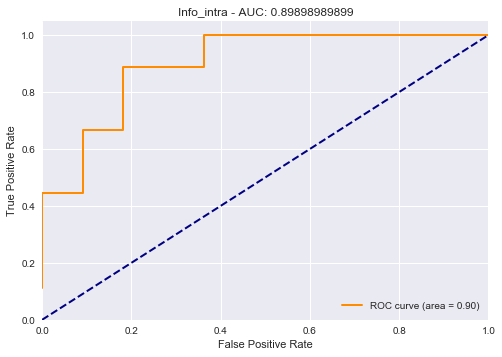

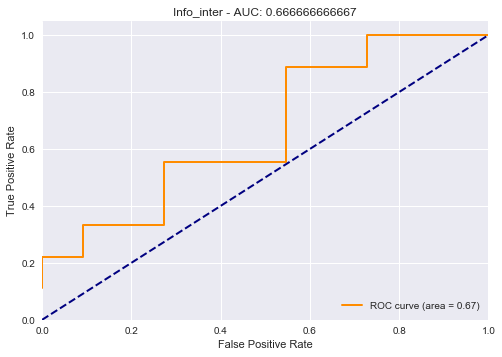

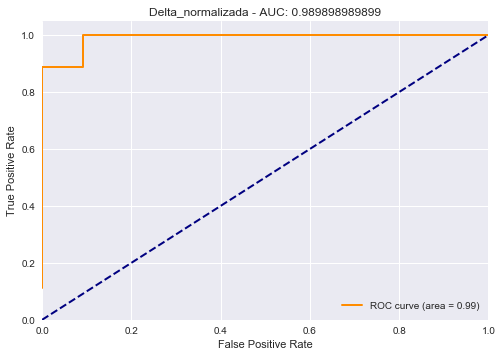

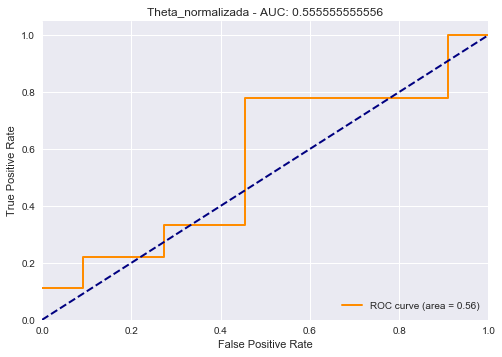

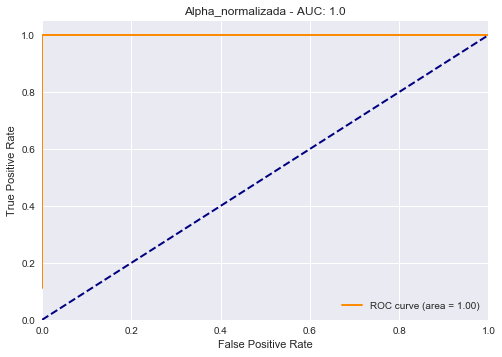

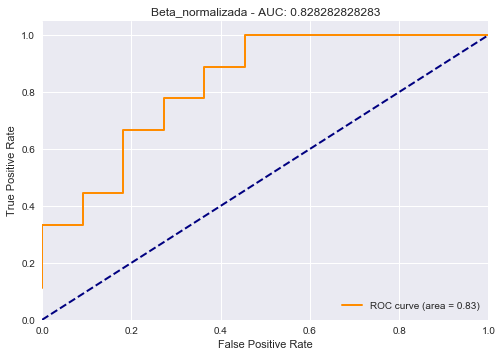

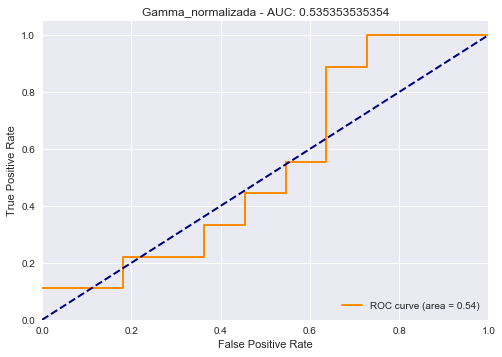

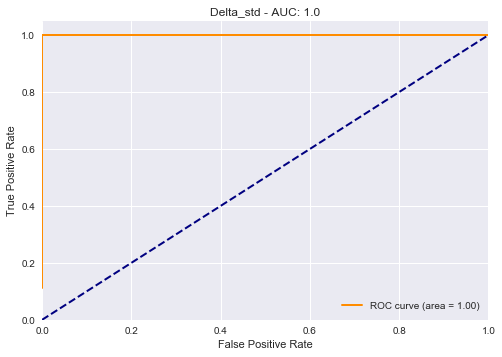

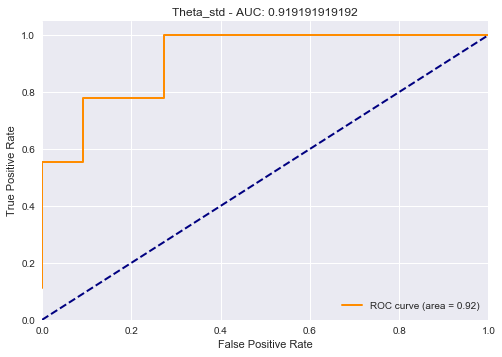

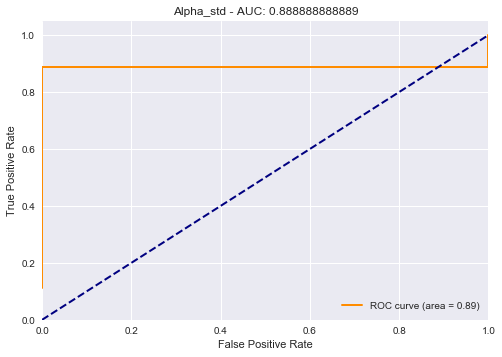

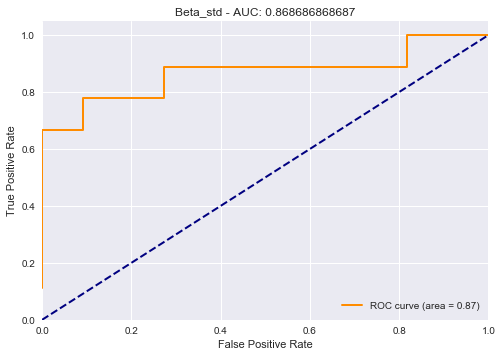

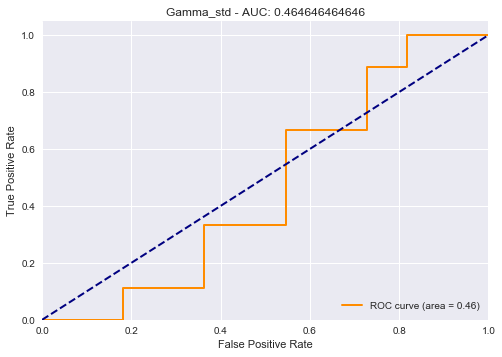

In [24]:
for feat in df.columns:
    if feat != "sujeto" and feat != "tipo":
        logistic_regression_roc(feat)


# Ejercicio 2a: Calculamos la cruva ROC usando Support Vector Machine

Notar que la curva roc tiene AUC 1, esto es debido a que los features alpha_normalizado y delta_std tienen AUC 1

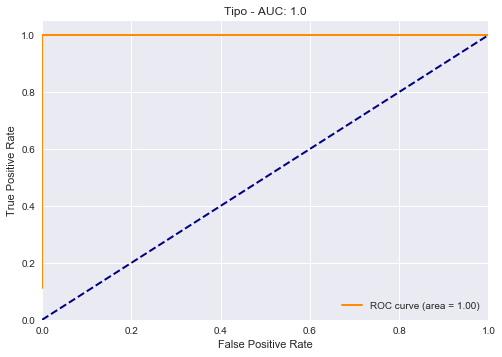

In [25]:
support_vector_machine_roc()

Lo mismo sucede secleccionando menos features, ya que con seleccionar uno solo alcanza para que la AUC sea 1.
    Notar que cuantos más features se usan, hay más grados de libertad y el modelo es más propenso a hacer over-fitting.

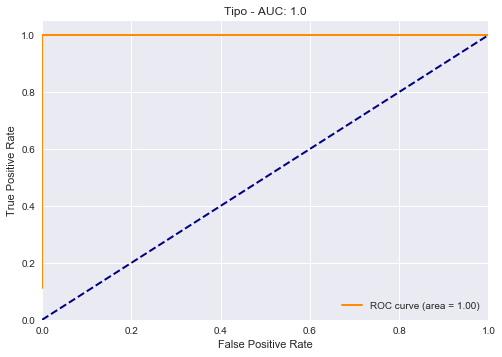

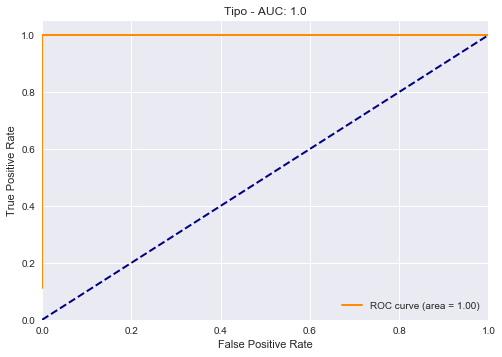

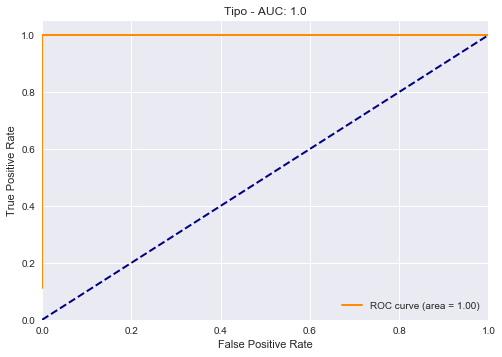

In [26]:
pipeline_svm_roc(10)
pipeline_svm_roc(20)
pipeline_svm_roc(35)